# Opening and Viewing Datacubes

In [1]:
import numpy as np
import os.path as op
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
plt.rcParams.update({'font.size': 12})

In [3]:
pdr1_dir = '/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/'

In [4]:
shotid = 20211202009
ifuslot = '048'

In [5]:
datacube_path = op.join( pdr1_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))

Each IFU datacube is named as `dex_cube_<SHOTID>_<IFUSLOT>.fits`, where:

- `<SHOTID>` corresponds to the observation ID (e.g., `20240731009`)
- `<IFUSLOT>` is the unique identifier of the IFU (e.g., `013`, `106`)

Each FITS file contains a 3D datacube organized as `(wavelength, y, x)` with:
- **Spectral resolution:** 1036 bins at 2 Å per pixel
- **Spatial resolution:** 104 × 104 pixels at 0.5 arcsec per pixel

| Extension | EXTNAME | Description                                                | Data Shape     |
|-----------|---------|------------------------------------------------------------|----------------|
| 0         | PRIMARY | Primary HDU (header only, no data)                         | None           |
| 1         | DATA    | Flux datacube in units of erg s⁻¹ cm⁻² Å⁻¹                | (104, 104, 1036) |
| 2         | ERROR   | 1σ error estimates (same units as DATA)                    | (104, 104, 1036) |
| 3         | MASK    | Bitmask per voxel indicating quality flags                 | (104, 104, 1036) |

Let's explore an example datacube:

In [6]:
hdul = fits.open( datacube_path)

In [7]:
hdul.info()

Filename: /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20211202009/dex_cube_20211202009_048.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  DATA          1 CompImageHDU     75   (104, 104, 1036)   float32   
  2  ERROR         1 CompImageHDU     75   (104, 104, 1036)   float32   
  3  MASK          1 CompImageHDU     75   (104, 104, 1036)   int16   


In [8]:
flux = hdul["DATA"].data
error = hdul["ERROR"].data
mask = hdul["MASK"].data
header = hdul["DATA"].header
wcs = WCS(header)

In [9]:
# information about the IFU observation can be found 
header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  104                                                  
NAXIS2  =                  104                                                  
NAXIS3  =                 1036                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 52.0 / Pixel coordinate of reference point            
CRPIX2  =                 52.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
PC1_1   =    -0.459771952587

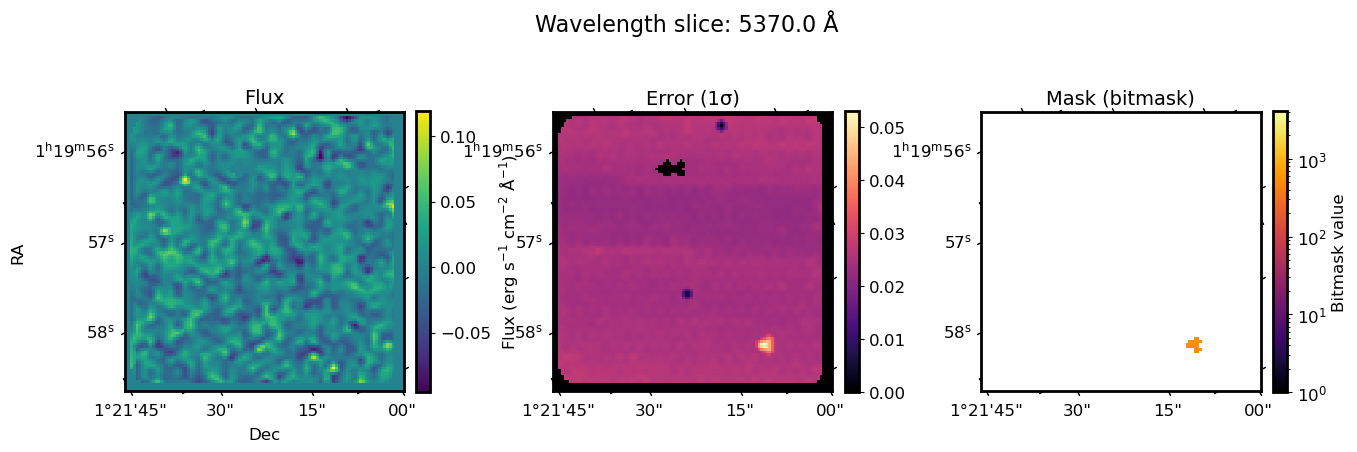

In [10]:
# Select a wavelength slice (e.g., central wavelength)
z_index = 950

# Get corresponding wavelength (in Å)
wavelength_angstrom = wcs.wcs_pix2world(0, 0, z_index, 0)[2]

# Slice the cube at the wavelength index
flux_slice = flux[z_index, :, :]
error_slice = error[z_index, :, :]
mask_slice = mask[z_index, :, :]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': wcs.celestial})
plt.subplots_adjust(wspace=0.4)

# Shared image display settings
im_kwargs = dict(origin='lower', interpolation='none')

# Panel 1: Flux
im0 = axes[0].imshow(flux_slice, cmap='viridis', **im_kwargs)
axes[0].set_title("Flux", fontsize=14)
axes[0].set_xlabel("RA", fontsize=12)
axes[0].set_ylabel("Dec", fontsize=12)
axes[0].coords[0].set_axislabel('RA')
axes[0].coords[1].set_axislabel('Dec')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")

# Panel 2: Error
im1 = axes[1].imshow(error_slice, cmap='magma', **im_kwargs)
axes[1].set_title("Error (1σ)", fontsize=14)
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords[0].set_axislabel('')
axes[1].coords[1].set_axislabel('')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Panel 3: Mask
im2 = axes[2].imshow(mask_slice, cmap='inferno', norm=LogNorm(vmin=1, vmax=4096), **im_kwargs)
axes[2].set_title("Mask (bitmask)", fontsize=14)
axes[2].set_xlabel("RA")
axes[2].set_ylabel("Dec")
axes[2].coords[0].set_axislabel('')
axes[2].coords[1].set_axislabel('')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label="Bitmask value")

# Title with wavelength
plt.suptitle(f"Wavelength slice: {wavelength_angstrom:.1f} Å", fontsize=16)

plt.show()

In [11]:
# close the fits HDU when done
hdul.close()